---
layout: page
title: Inflation and Interest Rates
---

In [16]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pytz
from collections import namedtuple
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from IPython.display import display, Markdown

from data_loader import load_csv_data, get_last_publish_date
from chart_format import StandardChart, PercentileChart

In [17]:
""" Load dataframes from other notebooks """
df_inflation = pd.DataFrame()
df_interest = pd.DataFrame()
%store -r df_inflation
%store -r df_interest

In [18]:
""" Chart variables """
start_date = pd.to_datetime('1960-01-01')
end_date = pd.to_datetime('2025-01-01') # used to force chart to plot to end of 5 year period
df_interest = df_interest.loc[df_interest.index >= start_date]
df_inflation = df_inflation.loc[df_inflation.index >= start_date]
interest_column = 'FILRHLBVS'
inflation_column = 'GCPIAGYP'
# Set 'last_index' to the last date with a valid value (so I can display 'as of <date>' in chart title)
last_index = df_interest[interest_column].last_valid_index()

In [19]:
def add_horizontal_band(plt):
    # Add a horizontal band between y=2 and y=3
    plt.fill_between(df_inflation.index, 2, 3, color=colors[1]['color'], alpha=0.1)
    # Create a Patch for the legend
    target_range = mpatches.Patch(color=colors[1]['color'], alpha=0.1, label='Target Inflation Range')
    # Get the existing legend entries
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    # Add the patch to the existing handles
    handles.append(target_range)
    plt.legend(handles=handles, loc=chart_params['legend_location'])
    return plt

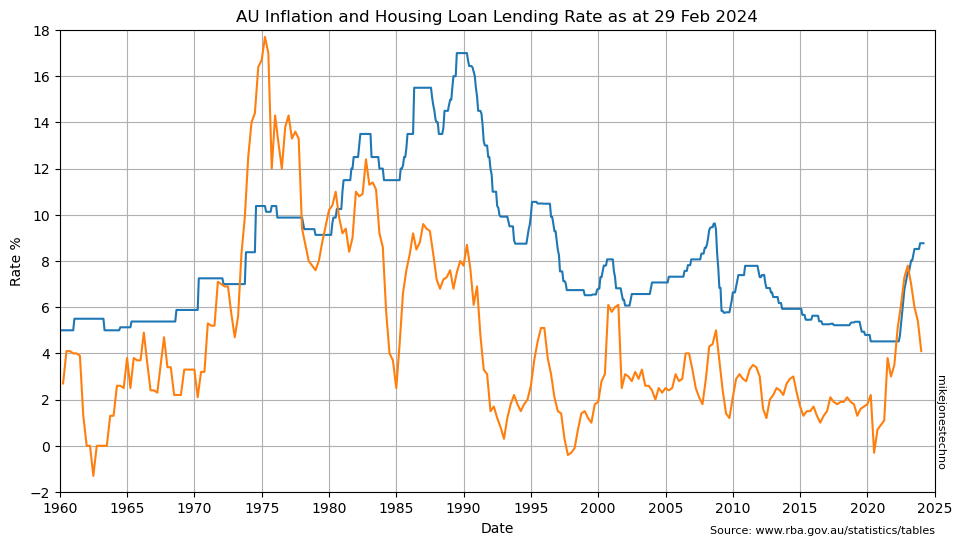

In [20]:
""" Show simple chart """

chart_params = {
    'chart_title': 'AU Inflation and Housing Loan Lending Rate as at ' + last_index.strftime('%d %b %Y'), 
    'chart_source': 'Source: www.rba.gov.au/statistics/tables', 
    'y_label': 'Rate %', 
    'y_ticks': 2,
    'x_label': 'Date', 
    'x_ticks': 5,
    'start_year': 1960,
    'data_column': inflation_column
}

standard_chart = StandardChart(**chart_params)
plt, colors = standard_chart.base_chart(df_inflation)

plt.plot(df_interest.index, df_interest[interest_column], color=colors[0]['color'])
plt.plot(df_inflation.index, df_inflation[inflation_column], color=colors[1]['color'])
#plt = add_horizontal_band(plt)
plt.show()

In [21]:
""" Calculate median 50th and lower, upper percentiles over multiple years """
multi_years = [10, 20, 30]

# Define the percentiles and window sizes
Percentiles = namedtuple('Percentiles', ['lower', 'median', 'upper'])
percentiles = Percentiles(25, 50, 75)

In [22]:
chart_params['color_index'] = 1
chart_params['legend_location'] = 'best'
chart_params['data_column'] = inflation_column
#percentile_chart = PercentileChart(percentiles, multi_years[1], **chart_params)
#plt = percentile_chart.plot_percentiles(df_inflation) 
##plt.plot_percentiles(df_interest, interest_column ) 
#plt = add_horizontal_band(plt)
#plt.show()